In [104]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

In [8]:

def paint_rectangle(image_path, top_left, bottom_right, output_path="output_image.png"):
    """
    Paints a rectangle in red over the image.

    Parameters:
    - image_path (str): Path to input image.
    - top_left (tuple): (x, y) of top-left corner.
    - bottom_right (tuple): (x, y) of bottom-right corner.
    - output_path (str): Path to save modified image.
    """
    img = cv2.imread(image_path)

    if img is None:
        raise IOError("Error: Could not read image.")

    # BGR format → Red = (0,0,255)
    cv2.rectangle(img, top_left, bottom_right, (0, 0, 255), thickness=-1)  # -1 = filled rectangle

    cv2.imwrite(output_path, img)

    cv2.imshow("Rectangle painted", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [14]:
paint_rectangle('2025-09-09-155110.jpg', (700, 320), (750, 360))

In [38]:
def extract_rgb_signals_rect(video_path, rect, output_csv="rgb_signals.csv"):
    """
    Extracts mean R, G, B signals from all pixels inside a rectangle across video frames.

    Parameters:
    - video_path (str): Path to input video.
    - rect (tuple): (x1, y1, x2, y2) defining the rectangle (top-left to bottom-right).
    - output_csv (str): Output CSV filename.
    """
    x1, y1, x2, y2 = rect
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Error opening video file.")

    signals = {"Mean_R": [], "Mean_G": [], "Mean_B": []}
    frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames += 1

        roi = frame[y1:y2, x1:x2]

        mean_b = np.mean(roi[:, :, 0])
        mean_g = np.mean(roi[:, :, 1])
        mean_r = np.mean(roi[:, :, 2])

        signals["Mean_R"].append(mean_r)
        signals["Mean_G"].append(mean_g)
        signals["Mean_B"].append(mean_b)

    cap.release()
    print(frames)

    df = pd.DataFrame(signals)
    df.to_csv(output_csv, index=False)

    return df

In [37]:
extract_rgb_signals_rect("2025-09-09-155113.webm", (615, 175, 700, 215), output_csv="rgb_signals.csv")

298


[ WARN:0@1415.707] global cap_ffmpeg_impl.hpp:1541 grabFrame packet read max attempts exceeded, if your video have multiple streams (video, audio) try to increase attempt limit by setting environment variable OPENCV_FFMPEG_READ_ATTEMPTS (current value is 4096)


,Mean_R,Mean_G,Mean_B
0,123.870294,74.538529,69.206765
1,123.870294,74.538529,69.206765
2,123.870588,74.538824,69.207059
3,123.870588,74.538824,69.207059
4,123.870882,74.539118,69.207353
...,...,...,...
293,125.265000,75.405882,70.358824
294,124.881765,75.575000,70.348529
295,124.771176,75.619706,70.335588
296,124.562353,75.415588,70.131471


In [57]:
def plot_rgb_signals(df, fps=30):
    """
    Plot R, G, B signals for a given pixel index in time and frequency domains.

    Parameters:
    - df (pd.DataFrame): DataFrame with extracted signals.
    - fps (int): Frames per second of the video.
    - pixel_idx (int): Index of pixel to plot (0, 1, 2, ...).
    """
    # Extract signals
    r = df[f"Mean_R"].values
    g = df[f"Mean_G"].values
    b = df[f"Mean_B"].values

    n = len(r)
    t = np.arange(n) / fps  # time in seconds

    # === Time domain plots ===
    plt.figure(figsize=(12, 5))
    plt.plot(t, r, label="R", color="red")
    plt.plot(t, g, label="G", color="green")
    plt.plot(t, b, label="B", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity")
    plt.title(f"RGB signals in time domain")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Frequency domain plots ===
    freqs = np.fft.rfftfreq(n, d=1/fps)  # frequency axis
    r_fft = np.abs(np.fft.rfft(r - np.mean(r)))  # remove DC
    g_fft = np.abs(np.fft.rfft(g - np.mean(g)))
    b_fft = np.abs(np.fft.rfft(b - np.mean(b))
    )

    plt.figure(figsize=(12, 5))
    plt.plot(freqs, r_fft, label="R", color="red")
    plt.plot(freqs, g_fft, label="G", color="green")
    plt.plot(freqs, b_fft, label="B", color="blue")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"RGB signals in frequency domain")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [52]:
df = pd.read_csv('rgb_signals.csv')

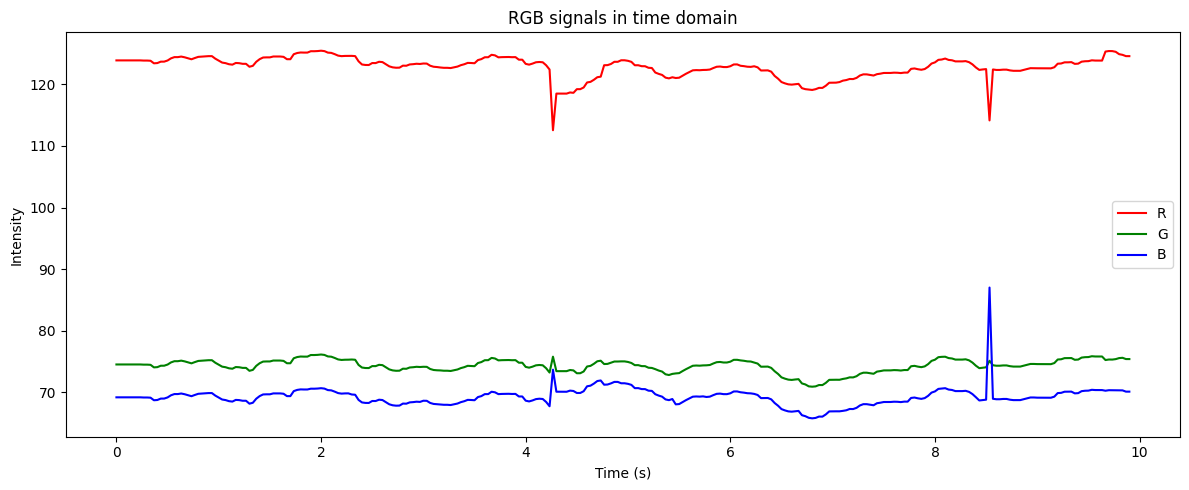

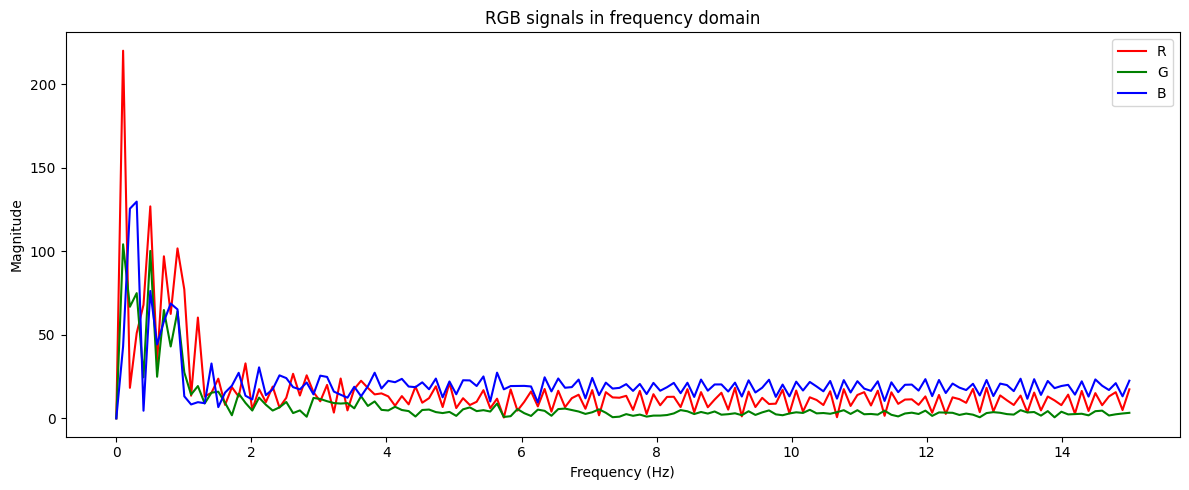

In [53]:
plot_rgb_signals(df)

In [48]:
paint_rectangle('android.jpeg', (750, 175), (875, 250))

In [49]:
extract_rgb_signals_rect("android.mp4", (750, 175, 875, 250), output_csv="rgb_signals_android.csv");

1218


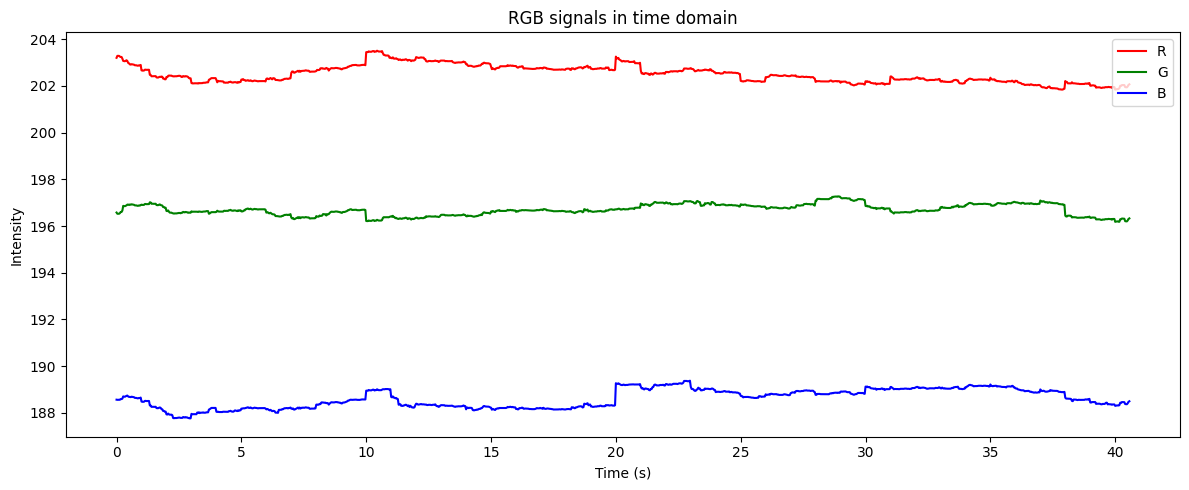

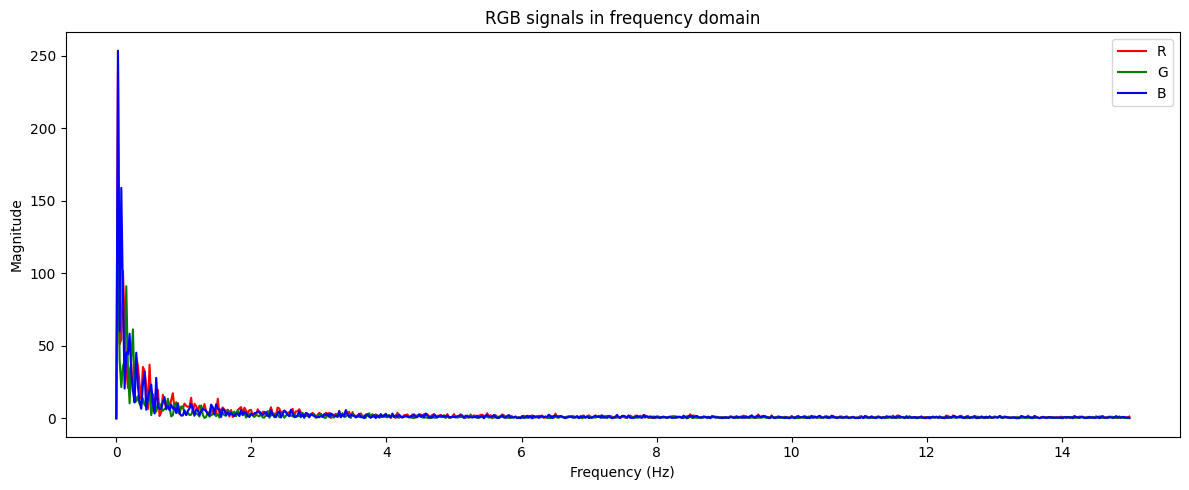

In [54]:
plot_rgb_signals(pd.read_csv('rgb_signals_android.csv'))

In [102]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def plot_filtered_signals(df, lowcut, highcut, filter_order=4, fps=30):
    """
    Plot filtered R, G, B signals in time and frequency domains
    using subplots (3x2: R,G,B rows and Time/Freq columns).
    """
    r_raw = df["Mean_R"].values
    g_raw = df["Mean_G"].values
    b_raw = df["Mean_B"].values

    r = butter_bandpass_filter(r_raw, lowcut, highcut, fs=fps, order=filter_order)
    g = butter_bandpass_filter(g_raw, lowcut, highcut, fs=fps, order=filter_order)
    b = butter_bandpass_filter(b_raw, lowcut, highcut, fs=fps, order=filter_order)

    n = len(r)
    t = np.arange(n) / fps

    freqs = np.fft.rfftfreq(n, d=1/fps)
    r_fft = np.abs(np.fft.rfft(r - np.mean(r)))
    g_fft = np.abs(np.fft.rfft(g - np.mean(g)))
    b_fft = np.abs(np.fft.rfft(b - np.mean(b)))

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f"RGB Signals (filtered {lowcut}-{highcut} Hz)", fontsize=14)

    axes[0,0].plot(t, r, color='red')
    axes[0,0].set_title('R - Time')
    axes[0,0].set_ylabel('Intensity')
    
    axes[1,0].plot(t, g, color='green')
    axes[1,0].set_title('G - Time')
    axes[1,0].set_ylabel('Intensity')
    
    axes[2,0].plot(t, b, color='blue')
    axes[2,0].set_title('B - Time')
    axes[2,0].set_xlabel('Time (s)')
    axes[2,0].set_ylabel('Intensity')

    axes[0,1].plot(freqs, r_fft, color='red')
    axes[0,1].set_title('R - Frequency')
    
    axes[1,1].plot(freqs, g_fft, color='green')
    axes[1,1].set_title('G - Frequency')
    
    axes[2,1].plot(freqs, b_fft, color='blue')
    axes[2,1].set_title('B - Frequency')
    axes[2,1].set_xlabel('Frequency (Hz)')

    for ax in axes[:,1]:
        ax.set_xlim(0, 1)
        ax.set_ylabel('Magnitude')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

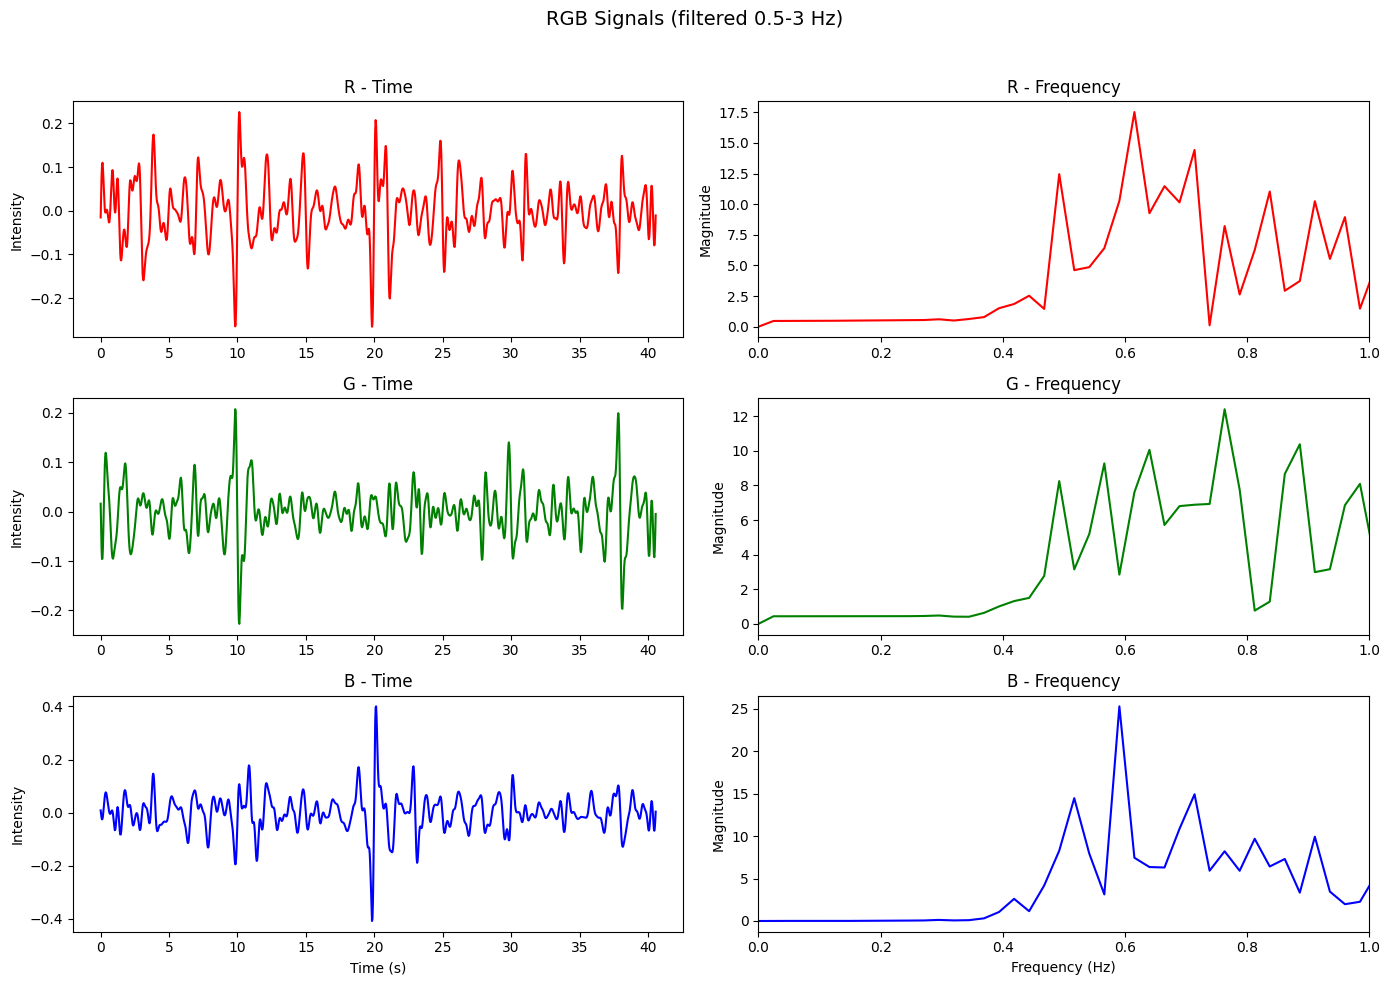

In [103]:
plot_filtered_signals(pd.read_csv('rgb_signals_android.csv'), 0.5, 3, 5)

In [107]:
def plot_rgb_spectrograms(df, fps=30, nperseg=256, noverlap=128, fmax=5):
    """
    Plot spectrograms of R, G, and B signals.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns ['Mean_R','Mean_G','Mean_B']
    - fps (int): Sampling rate (frames per second)
    - nperseg (int): Window length for FFT
    - noverlap (int): Overlap between windows
    - fmax (float): Max frequency (Hz) to display on y-axis
    """
    signals = {
        "R": df["Mean_R"].values,
        "G": df["Mean_G"].values,
        "B": df["Mean_B"].values
    }

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    fig.suptitle("Spectrograms of RGB Signals", fontsize=14)

    for ax, (label, sig, color) in zip(
        axes, 
        zip(["R","G","B"], signals.values(), ['Reds','Greens','Blues'])
    ):
        f, t, Sxx = spectrogram(sig, fs=fps, nperseg=nperseg, noverlap=noverlap)
        # Limit frequency axis
        mask = f <= fmax
        im = ax.pcolormesh(t, f[mask], 10*np.log10(Sxx[mask,:]+1e-12),
                           shading='gouraud', cmap=color)
        ax.set_ylabel('Freq (Hz)')
        ax.set_title(f'{label} channel')
        ax.set_ylim(0, fmax)
        fig.colorbar(im, ax=ax, orientation='vertical', label='Power (dB)')

    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

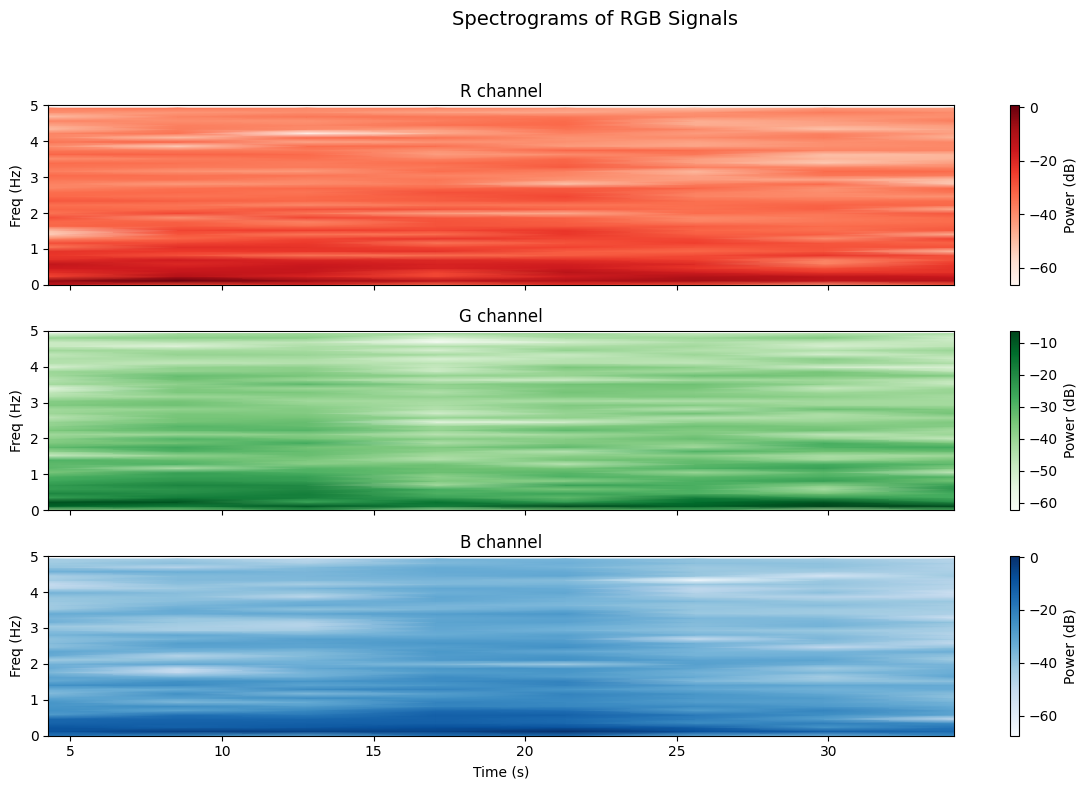

In [108]:
plot_rgb_spectrograms(pd.read_csv('rgb_signals_android.csv'))